## Momentum Trading Strategy Backtest

**Summary of project:**

### Libraries 

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import quantstats as qs
import warnings

## Importing ETFs 

### **Moving Average Convergence Divergence**





**What is an EMA (Exponential Moving Average):**    

A moving average that puts more weight on recent prices so it reacts faster to new information than a simple moving average. 

For price $P_t$:    
$$
EMA_t = {\alpha}P_t+(1-\alpha)EMA_{t-1}
$$
where   
$$
\alpha =\frac{2}{N+1}
$$ 

and N is the lookback window, typically 12 days (fast EMA- half trading month) or 26 days (slow EMA- full trading month).


**Features**:
- The weight on prices decays so that observaions older than about N period contribute very little
- Each day back gets less importance than the day after it, so a 12 day or 26 day EMA still includes prices before that






**Advantages**

- EMA responds faster to recent price changes as today's weight has a big weight
- Simple moving average (SMA) would need days to notice

**MACD Line**    
- Measures momentum by asking if price rising daster now than it was recently by comparin a fast reaction to a slow reaction to price.
- The MACD line is defined by   

$$  
MACD = EMA_{12} - EMA_{26}  
$$


Interpretation of MACD as a momentum gap (divergence) : 
- MACD > 0 $\rightarrow$ to short-term momentum > long-term momentum (bullish signal)
- MACD < 0 $\rightarrow$ short-term momentum < long-term momentum (bearish signal)

**Step 1: Extract Apple Data**
    

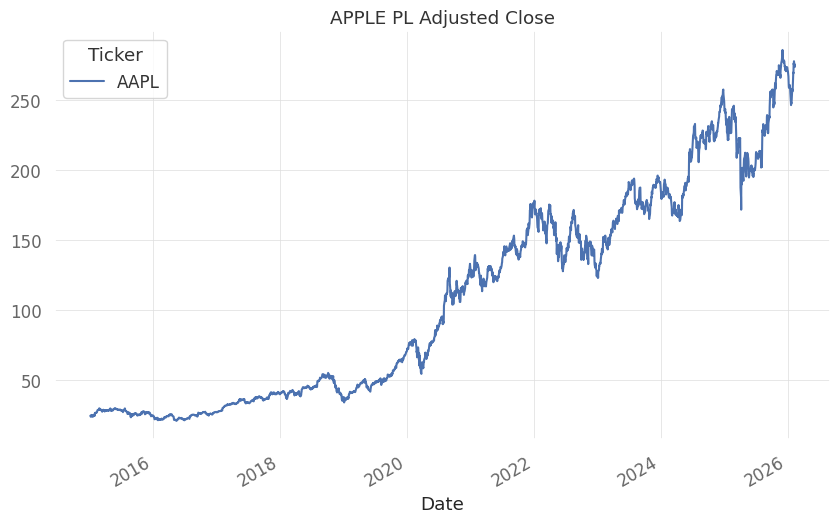

In [3]:
def download_stock_data(ticker, start_date):
    """Download and prepare stock data"""
    data = yf.download(
        ticker,
        start=start_date,
        auto_adjust=True,
        progress=False
    )
    return data['Close']

# Download Apple data
prices = download_stock_data("AAPL", "2015-01-01")
prices.plot(title="APPLE PL Adjusted Close")
plt.show()


**Step 2: Compute MACD**


In [4]:

def calculate_macd(prices, fast_span=12, slow_span=26, signal_span=9):
    """Calculate MACD components"""
    ema_fast = prices.ewm(span=fast_span, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_span, adjust=False).mean()
    
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_span, adjust=False).mean()
    histogram = macd_line - signal_line
    
    return macd_line, signal_line, histogram

# Calculate MACD
macd, signal, histogram = calculate_macd(prices)

# Generate trading signals
bullish_signals = ((macd > signal) & (macd.shift(1) <= signal.shift(1))).sum()
bearish_signals = ((macd < signal) & (macd.shift(1) >= signal.shift(1))).sum()

print(f"Bullish signals: {bullish_signals}")
print(f"Bearish signals: {bearish_signals}")



Bullish signals: Ticker
AAPL    100
dtype: int64
Bearish signals: Ticker
AAPL    100
dtype: int64


**Backtest framework over past 10 years vs Buy-Hold Strategy**

ticker: AAPL
start: 2015-01-01
end: 2026-02-11
initial_capital: 1000000.000000
ending_value_strategy: 7600963.942106
ending_value_buyhold: 11377295.622145
profit_strategy: 6600963.942106
profit_pct_strategy: 6.600964
max_drawdown_strategy: -0.270335
trades: 199
fee_rate_per_trade: 0.000500


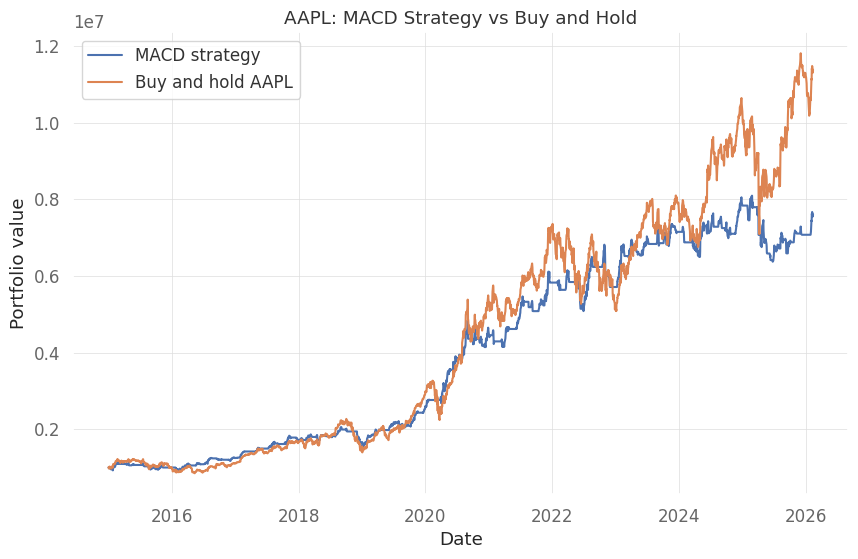

In [5]:

def backtest_macd(
    ticker: str = "AAPL",
    start: str = "2015-01-01",
    initial_capital: float = 1_000_000.0,
    fast_span: int = 12,
    slow_span: int = 26,
    signal_span: int = 9,
    fee_rate_per_trade: float = 0.0005
):
    data = yf.download(
        ticker,
        start=start,
        auto_adjust=True,
        progress=False
    )

    close = data["Close"]
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0]
    prices = close.dropna().astype(float)

    ema_fast = prices.ewm(span=fast_span, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_span, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_span, adjust=False).mean()
    hist = macd - signal

    raw_position = (macd > signal).astype(int)
    position = raw_position.shift(1).fillna(0).astype(int)

    returns = prices.pct_change().fillna(0.0)
    trades = position.diff().abs().fillna(0.0)

    strategy_returns_gross = position * returns
    strategy_returns_net = strategy_returns_gross - trades * fee_rate_per_trade

    equity_strategy = initial_capital * (1.0 + strategy_returns_net).cumprod()

    # Buy-and-hold benchmark (same initial capital)
    equity_buyhold = initial_capital * (prices / prices.iloc[0])

    final_value = float(equity_strategy.iloc[-1])
    profit = final_value - initial_capital
    profit_pct = final_value / initial_capital - 1.0

    running_max = equity_strategy.cummax()
    drawdown = equity_strategy / running_max - 1.0
    max_drawdown = float(drawdown.min())

    results = {
        "ticker": ticker,
        "start": start,
        "end": str(equity_strategy.index[-1].date()),
        "initial_capital": float(initial_capital),
        "ending_value_strategy": float(equity_strategy.iloc[-1]),
        "ending_value_buyhold": float(equity_buyhold.iloc[-1]),
        "profit_strategy": float(profit),
        "profit_pct_strategy": float(profit_pct),
        "max_drawdown_strategy": float(max_drawdown),
        "trades": int(trades.sum()),
        "fee_rate_per_trade": float(fee_rate_per_trade),
    }

    return prices, macd, signal, hist, position, equity_strategy, equity_buyhold, results


# ---- Run ----
prices, macd, signal, hist, position, equity_strategy, equity_buyhold, results = backtest_macd(
    ticker="AAPL",
    start="2015-01-01",
    initial_capital=1_000_000.0,
    fee_rate_per_trade=0.0005
)

for k, v in results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.6f}")
    else:
        print(f"{k}: {v}")

# ---- Plot: strategy vs buy-and-hold ----
plt.figure()
plt.plot(equity_strategy, label="MACD strategy")
plt.plot(equity_buyhold, label="Buy and hold AAPL")
plt.title("AAPL: MACD Strategy vs Buy and Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.show()




**The Visual Narrative**    

The orange line (buy and hold) grows faster in strong bull markets

The blue line (MACD) is smoother but **lags** badly when Apple trends strongly upward

Key visual insights:

*1) 2019–2021 bull market*

- Buy and hold explodes upward

- MACD repeatedly exits and re-enters

- This causes missed upside

*2)2022 market crash*

- Buy and hold falls hard

- MACD falls much less

*3) Post-2023 recovery*

- Buy and hold again dominates

- MACD stays cautious and under-participates

**STEP 5: COVID PERIOD ANALYSIS**

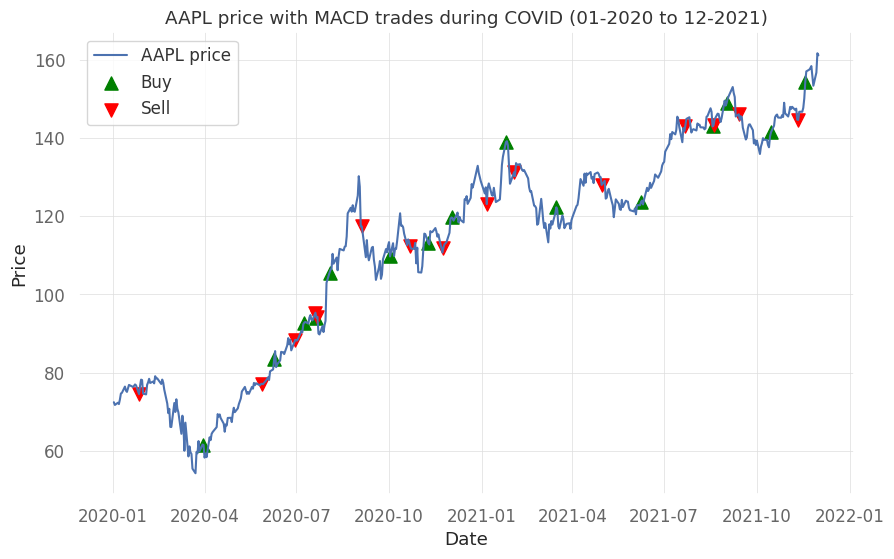

In [6]:
# Analyze COVID period (2020-01-01 to 2021-12-01)
covid_start = "2020-01-01"
covid_end = "2021-12-01"

# Slice data for COVID period
px_covid = prices.loc[covid_start:covid_end]
pos_covid = position.reindex(px_covid.index).fillna(0).astype(int)

# Get entry and exit dates
changes = pos_covid.diff().fillna(0)
buy_dates = changes[changes == 1].index
sell_dates = changes[changes == -1].index

# Visualize
plt.figure()
plt.plot(px_covid.index, px_covid.values, label="AAPL price")
plt.scatter(buy_dates, px_covid.loc[buy_dates], marker="^", s=90, label="Buy", color='green')
plt.scatter(sell_dates, px_covid.loc[sell_dates], marker="v", s=90, label="Sell", color='red')
plt.title("AAPL price with MACD trades during COVID (01-2020 to 12-2021)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()




In [ ]:

warnings.filterwarnings('ignore')

# Calculate returns
strategy_returns = equity_strategy.pct_change().dropna()
benchmark_returns = equity_buyhold.pct_change().dropna()

# Align dates
df = pd.concat([strategy_returns, benchmark_returns], axis=1).dropna()

# Generate HTML report
qs.reports.html(
    df.iloc[:, 0],
    benchmark=df.iloc[:, 1],
    output="report.html",
    title="Strategy vs Benchmark"
)

print("Done: performancereportMACD.html")




#### **Risk Summary**

1) **Volatility and risk-adjusted returns**
- *Annualised volatility*: Strategy 17.99% vs Buy&Hold 28.78%.
  Interpretation: strategy materially reduced day-to-day variability via regime filtering / partial exposure.

- *Sharpe ratio*: Strategy 1.11 vs Buy&Hold 0.90.
  Interpretation: higher return per unit of total risk, despite lower absolute return.

- *Sortino ratio*: Strategy 1.66 vs Buy&Hold 1.32.
  Interpretation: better downside-risk control (loss-focused risk adjustment).

2) **Drawdown severity and recovery**
- *Maximum drawdown*: Strategy −27.03% vs Buy&Hold −38.52%.
  Interpretation: strategy preserved capital better in the worst peak-to-trough episode.

- **Longest drawdown duration*: Strategy 508 days vs Buy&Hold 617 days.**
  Interpretation: less time spent underwater, improved recovery profile.

- *Ulcer Index*: Strategy 0.08 vs Buy&Hold 0.12.
  Interpretation: drawdowns were not only smaller, but also less persistent.

3) **Tail risk (extreme downside days)**
- *Daily VaR*: Strategy −1.78% vs Buy&Hold −2.88%.
- *Expected Shortfall (CVaR)*: Strategy −2.85% vs Buy&Hold −4.26%.
  Interpretation: substantially reduced exposure to extreme downside outcomes.

- *Worst year*: Strategy −9.72% vs Buy&Hold −26.40% (macro tightening / risk-off regime, 2022).
  Interpretation: trend-following / exposure-reduction helped during a macro shock period.

**Macro explanation** (why the pattern occurred)
- AAPL experienced long, structurally bullish periods (especially 2019–2021, 2023–2024), where continuous exposure wins.
- MACD is defensive by construction: it exits when momentum weakens, protecting during macro stress (e.g., tightening cycles),
  but it can miss sharp liquidity-driven rebounds and extended rallies.
- Time-in-market is the dominant structural driver:
  Strategy time-in-market 55% vs Buy&Hold 100% → lower participation in long bull runs.

**Behavioural / psychological implications**
- *Loss aversion and capitulation risk*:
  Buy&Hold max DD −38.52% is in the zone where many investors panic-sell.
  Strategy max DD −27.03% reduces the probability of abandoning the system at the worst moment.

- *Adherence / staying invested*:
  Lower volatility (17.99%), smaller tail losses (CVaR −2.85%), and shorter drawdown duration (508 days)
  improve the odds of consistent strategy adherence, which is often more important than backtest “peak” returns.

**Conclusion**

This MACD implementation behaves as a drawdown-control and behavioural-risk mitigation overlay:
it trades upside capture for smoother returns and smaller crashes (higher Sharpe/Sortino, lower DD and tail risk),
but underperforms buy-and-hold during long, strong equity uptrends due to reduced time-in-market (55%).

